In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# names of ibi features
ibicol = ['mean_nni', 'sdnn', 'sdsd', 'nni_50','pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 
          'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr',
          'std_hr','lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']

base_merged = pd.read_csv(r'./features/base_merged.csv').set_index(["participant"], drop=True)
session_merged = pd.read_csv(r'./features/session_merged.csv').set_index(["participant"], drop=True)

base_df = base_merged[['Time','filtered_eda','AccelMagnitude','Temp']+ibicol].assign(label=0)
session_df = session_merged[['Time','filtered_eda','AccelMagnitude','Temp']+ibicol].assign(label=1)
data = pd.concat([base_df,session_df]).dropna()
# data with ibi features, EDA, ACC, TEMP and without peaks
data

,Time,filtered_eda,AccelMagnitude,Temp,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,...,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,label
participant,,,,,,,,,,,,,,,,,,,,,
2,2019-09-05 18:10:37,0.135859,63.663176,33.13,711.994631,91.463608,5.060227e+01,12.0,19.672131,29.0,...,62.947914,10.656406,2509.662835,837.199569,2.997688,74.985540,25.014460,6220.193702,2873.331298,0
2,2019-09-05 18:10:49,0.137880,63.725976,33.09,712.011693,80.769210,4.781323e+01,13.0,17.333333,38.0,...,63.997065,9.659613,1887.511812,737.751148,2.558467,71.898009,28.101991,4684.443938,2059.180978,0
2,2019-09-05 18:10:50,0.137427,63.725976,33.07,709.094893,76.343341,4.644713e+01,12.0,16.000000,38.0,...,67.365320,9.338671,1758.296342,534.324534,3.290690,76.693725,23.306275,4093.939978,1801.319102,0
2,2019-09-05 18:10:50,0.137427,63.725976,33.07,707.011467,75.173212,4.447323e+01,11.0,14.666667,38.0,...,67.365320,9.221424,1726.405165,501.694445,3.441149,77.483303,22.516697,3887.995994,1659.896384,0
2,2019-09-05 18:10:51,0.137056,63.725976,33.07,707.011467,75.173212,4.462336e+01,11.0,14.666667,39.0,...,67.365320,9.221424,1726.451996,502.411399,3.436331,77.458852,22.541148,3877.445538,1648.582143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,2019-10-22 21:30:57,0.055286,64.039051,27.29,679.719000,54.690000,5.684342e-14,2.0,66.666667,2.0,...,81.698345,5.843102,0.000000,458.478741,0.000000,0.000000,100.000000,458.478741,0.000000,1
37,2019-10-22 21:31:04,0.057024,64.039051,27.27,764.097200,90.844287,5.078350e+01,2.0,40.000000,2.0,...,66.203901,7.784961,1110.022213,1630.937377,0.680604,40.497577,59.502423,2740.959590,0.000000,1
37,2019-10-22 21:31:15,0.054994,64.039051,27.27,699.250833,38.195125,3.365871e+01,1.0,16.666667,2.0,...,81.698345,4.623697,177.596512,287.191239,0.618391,38.210239,61.789761,464.787751,0.000000,1


In [2]:
# split data set
data = data.drop(['Time'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.label, test_size=0.2,random_state=42)
scaler = preprocessing.MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
%%time
# Train classifiers to find the parameters of best perfromance
C_range = np.logspace(-2, 5, 8)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range,kernel = ['rbf'])
grid = GridSearchCV(SVC(), param_grid=param_grid,refit = True, verbose = 3)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
# print how our model looks after hyper-parameter tuning 
print('Best estimator: ', grid.best_estimator_) 

grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

Fitting 5 folds for each of 104 candidates, totalling 520 fits
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.727, total=  10.9s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.727, total=  10.9s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s


[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.727, total=  10.9s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.727, total=  10.9s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.727, total=  10.9s
[CV] C=0.01, gamma=1e-08, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-08, kernel=rbf, score=0.727, total=  12.2s
[CV] C=0.01, gamma=1e-08, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-08, kernel=rbf, score=0.727, total=  12.2s
[CV] C=0.01, gamma=1e-08, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-08, kernel=rbf, score=0.727, total=  12.1s
[CV] C=0.01, gamma=1e-08, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-08, kernel=rbf, score=0.727, total=  12.1s
[CV] C=0.01, gamma=1e-08, kernel=rbf .................................
[CV] .

[CV] .... C=0.01, gamma=1000.0, kernel=rbf, score=0.727, total=  31.5s
[CV] C=0.01, gamma=1000.0, kernel=rbf ................................
[CV] .... C=0.01, gamma=1000.0, kernel=rbf, score=0.727, total=  31.3s
[CV] C=0.01, gamma=1000.0, kernel=rbf ................................
[CV] .... C=0.01, gamma=1000.0, kernel=rbf, score=0.727, total=  31.1s
[CV] C=0.01, gamma=1000.0, kernel=rbf ................................
[CV] .... C=0.01, gamma=1000.0, kernel=rbf, score=0.727, total=  31.4s
[CV] C=0.01, gamma=1000.0, kernel=rbf ................................
[CV] .... C=0.01, gamma=1000.0, kernel=rbf, score=0.727, total=  31.3s
[CV] C=0.1, gamma=1e-09, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=1e-09, kernel=rbf, score=0.727, total=  10.9s
[CV] C=0.1, gamma=1e-09, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=1e-09, kernel=rbf, score=0.727, total=  10.9s
[CV] C=0.1, gamma=1e-09, kernel=rbf ..................................
[CV] .

[CV] ....... C=0.1, gamma=10.0, kernel=rbf, score=0.891, total=  11.2s
[CV] C=0.1, gamma=10.0, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=10.0, kernel=rbf, score=0.902, total=  11.2s
[CV] C=0.1, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=100.0, kernel=rbf, score=0.863, total=  18.6s
[CV] C=0.1, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=100.0, kernel=rbf, score=0.863, total=  18.6s
[CV] C=0.1, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=100.0, kernel=rbf, score=0.864, total=  22.2s
[CV] C=0.1, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=100.0, kernel=rbf, score=0.864, total=  18.4s
[CV] C=0.1, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=100.0, kernel=rbf, score=0.867, total=  18.2s
[CV] C=0.1, gamma=1000.0, kernel=rbf .................................
[CV] .

[CV] ........ C=1.0, gamma=1.0, kernel=rbf, score=0.850, total=  12.4s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=10.0, kernel=rbf, score=0.951, total=   6.8s
[CV] C=1.0, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=1.0, gamma=100.0, kernel=rbf, score=0.956, total=  32.5s
[CV] C=1.0, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=1.0, gamma=100.0, kernel=rbf, score=0.959, total=  32.3s
[CV] C=1.0, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=1.0, gamma=100.0, kernel=rbf, score=0.964, total=  32.2s
[CV] C=1.0, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=1.0, gamma=100.0, kernel=rbf, score=0.961, total=  32.0s
[CV] C=1.0, gamma=100.0, kernel=rbf ..................................
[CV] ...... C=1.0, gamma=100.0, kernel=rbf, score=0.962, total=  32.3s
[CV] C=1.0, gamma=1000.0, kernel=rbf .................................
[CV] .

[CV] ....... C=10.0, gamma=1.0, kernel=rbf, score=0.884, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] ....... C=10.0, gamma=1.0, kernel=rbf, score=0.887, total=  10.7s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] ....... C=10.0, gamma=1.0, kernel=rbf, score=0.880, total=  10.6s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] ....... C=10.0, gamma=1.0, kernel=rbf, score=0.885, total=  10.6s
[CV] C=10.0, gamma=10.0, kernel=rbf ..................................
[CV] ...... C=10.0, gamma=10.0, kernel=rbf, score=0.965, total=   4.7s
[CV] C=10.0, gamma=10.0, kernel=rbf ..................................
[CV] ...... C=10.0, gamma=10.0, kernel=rbf, score=0.965, total=   4.8s
[CV] C=10.0, gamma=10.0, kernel=rbf ..................................
[CV] ...... C=10.0, gamma=10.0, kernel=rbf, score=0.971, total=   4.8s
[CV] C=10.0, gamma=10.0, kernel=rbf ..................................
[CV] .

[CV] ...... C=100.0, gamma=0.1, kernel=rbf, score=0.841, total=  13.8s
[CV] C=100.0, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=100.0, gamma=0.1, kernel=rbf, score=0.837, total=  13.9s
[CV] C=100.0, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=100.0, gamma=0.1, kernel=rbf, score=0.838, total=  14.1s
[CV] C=100.0, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=100.0, gamma=0.1, kernel=rbf, score=0.837, total=  13.9s
[CV] C=100.0, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=100.0, gamma=0.1, kernel=rbf, score=0.836, total=  13.9s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ...... C=100.0, gamma=1.0, kernel=rbf, score=0.924, total=  12.3s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ...... C=100.0, gamma=1.0, kernel=rbf, score=0.923, total=  12.4s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] ... C=1000.0, gamma=0.001, kernel=rbf, score=0.773, total=  15.7s
[CV] C=1000.0, gamma=0.001, kernel=rbf ...............................
[CV] ... C=1000.0, gamma=0.001, kernel=rbf, score=0.771, total=  15.4s
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] .... C=1000.0, gamma=0.01, kernel=rbf, score=0.817, total=  16.0s
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] .... C=1000.0, gamma=0.01, kernel=rbf, score=0.820, total=  15.8s
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] .... C=1000.0, gamma=0.01, kernel=rbf, score=0.819, total=  15.8s
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] .... C=1000.0, gamma=0.01, kernel=rbf, score=0.819, total=  15.8s
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] .... C=1000.0, gamma=0.01, kernel=rbf, score=0.818, total=  16.1s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .

[CV] . C=10000.0, gamma=0.0001, kernel=rbf, score=0.776, total=  15.6s
[CV] C=10000.0, gamma=0.0001, kernel=rbf .............................
[CV] . C=10000.0, gamma=0.0001, kernel=rbf, score=0.776, total=  15.6s
[CV] C=10000.0, gamma=0.0001, kernel=rbf .............................
[CV] . C=10000.0, gamma=0.0001, kernel=rbf, score=0.770, total=  15.7s
[CV] C=10000.0, gamma=0.0001, kernel=rbf .............................
[CV] . C=10000.0, gamma=0.0001, kernel=rbf, score=0.769, total=  15.6s
[CV] C=10000.0, gamma=0.001, kernel=rbf ..............................
[CV] .. C=10000.0, gamma=0.001, kernel=rbf, score=0.800, total=  16.5s
[CV] C=10000.0, gamma=0.001, kernel=rbf ..............................
[CV] .. C=10000.0, gamma=0.001, kernel=rbf, score=0.806, total=  16.3s
[CV] C=10000.0, gamma=0.001, kernel=rbf ..............................
[CV] .. C=10000.0, gamma=0.001, kernel=rbf, score=0.801, total=  16.5s
[CV] C=10000.0, gamma=0.001, kernel=rbf ..............................
[CV] .

[CV] . C=100000.0, gamma=1e-06, kernel=rbf, score=0.741, total=  17.0s
[CV] C=100000.0, gamma=1e-05, kernel=rbf .............................
[CV] . C=100000.0, gamma=1e-05, kernel=rbf, score=0.779, total=  16.1s
[CV] C=100000.0, gamma=1e-05, kernel=rbf .............................
[CV] . C=100000.0, gamma=1e-05, kernel=rbf, score=0.782, total=  16.2s
[CV] C=100000.0, gamma=1e-05, kernel=rbf .............................
[CV] . C=100000.0, gamma=1e-05, kernel=rbf, score=0.780, total=  16.0s
[CV] C=100000.0, gamma=1e-05, kernel=rbf .............................
[CV] . C=100000.0, gamma=1e-05, kernel=rbf, score=0.776, total=  16.2s
[CV] C=100000.0, gamma=1e-05, kernel=rbf .............................
[CV] . C=100000.0, gamma=1e-05, kernel=rbf, score=0.778, total=  16.1s
[CV] C=100000.0, gamma=0.0001, kernel=rbf ............................
[CV]  C=100000.0, gamma=0.0001, kernel=rbf, score=0.787, total=  17.0s
[CV] C=100000.0, gamma=0.0001, kernel=rbf ............................
[CV]  

[Parallel(n_jobs=1)]: Done 520 out of 520 | elapsed: 216.8min finished


The best parameters are {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'} with a score of 0.97
Best estimator:  SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1581
           1       0.97      0.98      0.98      4361

    accuracy                           0.97      5942
   macro avg       0.96      0.95      0.96      5942
weighted avg       0.97      0.97      0.97      5942

CPU times: user 3h 36min 46s, sys: 6.74 s, total: 3h 36min 53s
Wall time: 3h 36min 52s


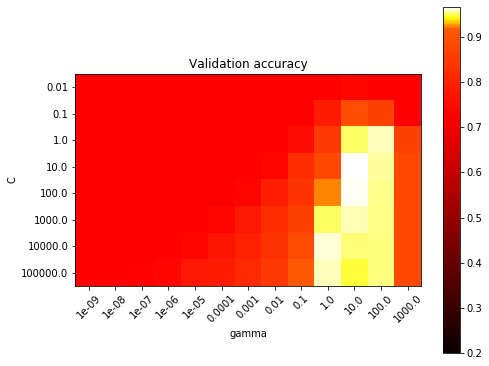

In [4]:
from matplotlib.colors import Normalize
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [2]:
%%time
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# names of ibi features
ibicol = ['mean_nni', 'sdnn', 'sdsd', 'nni_50','pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 
          'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr',
          'std_hr','lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']

base_merged = pd.read_csv(r'./features/base_merged.csv').set_index(["participant"], drop=True)
session_merged = pd.read_csv(r'./features/session_merged.csv').set_index(["participant"], drop=True)

base_df = base_merged[['Time','filtered_eda','AccelMagnitude','Temp']+ibicol].assign(label=0)
session_df = session_merged[['Time','filtered_eda','AccelMagnitude','Temp']+ibicol].assign(label=1)
data = pd.concat([base_df,session_df]).dropna()
data = data.drop(['Time'],axis=1)

# Train and predict using best paramters
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.label, test_size=0.2,random_state=43)
scaler = preprocessing.MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#Create a svm Classifier
clf = svm.SVC(C=10,gamma = 10, kernel='rbf')
#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9616290811174689
Precision: 0.9694232105628909
Recall: 0.9775753328661527
CPU times: user 7 s, sys: 95.2 ms, total: 7.1 s
Wall time: 7.1 s
